<a href="https://colab.research.google.com/github/raja-kumar/Hybrid-Quantization/blob/master/hybrid_quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision.models as models
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

model = models.resnet18(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [3]:
import math
import numpy as np
from torch.autograd import Function, Variable
import torch


def clamp(input, min, max, inplace=False):
    """
    Clamp tensor input to (min, max).
    input: input tensor to be clamped
    """

    if inplace:
        input.clamp_(min, max)
        return input
    return torch.clamp(input, min, max)


def linear_quantize(input, scale, zero_point, inplace=False):
    """
    Quantize single-precision input tensor to integers with the given scaling factor and zeropoint.
    input: single-precision input tensor to be quantized
    scale: scaling factor for quantization
    zero_pint: shift for quantization
    """

    # reshape scale and zeropoint for convolutional weights and activation
    if len(input.shape) == 4:
        scale = scale.view(-1, 1, 1, 1)
        zero_point = zero_point.view(-1, 1, 1, 1)
    # reshape scale and zeropoint for linear weights
    elif len(input.shape) == 2:
        scale = scale.view(-1, 1)
        zero_point = zero_point.view(-1, 1)
    # mapping single-precision input to integer values with the given scale and zeropoint
    if inplace:
        input.mul_(scale).sub_(zero_point).round_()
        return input
    return torch.round(scale * input - zero_point)


def linear_dequantize(input, scale, zero_point, inplace=False):
    """
    Map integer input tensor to fixed point float point with given scaling factor and zeropoint.
    input: integer input tensor to be mapped
    scale: scaling factor for quantization
    zero_pint: shift for quantization
    """

    # reshape scale and zeropoint for convolutional weights and activation
    if len(input.shape) == 4:
        scale = scale.view(-1, 1, 1, 1)
        zero_point = zero_point.view(-1, 1, 1, 1)
    # reshape scale and zeropoint for linear weights
    elif len(input.shape) == 2:
        scale = scale.view(-1, 1)
        zero_point = zero_point.view(-1, 1)
    # mapping integer input to fixed point float point value with given scaling factor and zeropoint
    if inplace:
        input.add_(zero_point).div_(scale)
        return input
    return (input + zero_point) / scale


def asymmetric_linear_quantization_params(num_bits,
                                          saturation_min,
                                          saturation_max,
                                          integral_zero_point=True,
                                          signed=True):
    """
    Compute the scaling factor and zeropoint with the given quantization range.
    saturation_min: lower bound for quantization range
    saturation_max: upper bound for quantization range
    """
    n = 2**num_bits - 1
    scale = n / torch.clamp((saturation_max - saturation_min), min=1e-8)
    zero_point = scale * saturation_min

    if integral_zero_point:
        if isinstance(zero_point, torch.Tensor):
            zero_point = zero_point.round()
        else:
            zero_point = float(round(zero_point))
    if signed:
        zero_point += 2**(num_bits - 1)
    return scale, zero_point


class AsymmetricQuantFunction(Function):
    """
    Class to quantize the given floating-point values with given range and bit-setting.
    Currently only support inference, but not support back-propagation.
    """
    @staticmethod
    def forward(ctx, x, k, x_min=None, x_max=None):
        """
        x: single-precision value to be quantized
        k: bit-setting for x
        x_min: lower bound for quantization range
        x_max=None
        """
        scale, zero_point = asymmetric_linear_quantization_params(
            k, x_min, x_max)
        new_quant_x = linear_quantize(x, scale, zero_point, inplace=False)
        n = 2**(k - 1)
        new_quant_x = torch.clamp(new_quant_x, -n, n - 1)
        quant_x = linear_dequantize(new_quant_x,
                                    scale,
                                    zero_point,
                                    inplace=False)
        return torch.autograd.Variable(quant_x)

    @staticmethod
    def backward(ctx, grad_output):
        raise NotImplementedError


In [4]:
def kl_div(p,q):
  return torch.sum(torch.sum((p * torch.log2(p/q)), dim=1))/p.shape[0]

In [5]:
def linear_quantize_pt(input, scale, zero_point, inplace=False):
    """
    Quantize single-precision input tensor to integers with the given scaling factor and zeropoint.
    input: single-precision input tensor to be quantized
    scale: scaling factor for quantization
    zero_pint: shift for quantization
    """

    # reshape scale and zeropoint for convolutional weights and activation
    ''' if len(input.shape) == 4:
        scale = scale.view(-1, 1, 1, 1)
        zero_point = zero_point.view(-1, 1, 1, 1)
    # reshape scale and zeropoint for linear weights
    elif len(input.shape) == 2:
        scale = scale.view(-1, 1)
        zero_point = zero_point.view(-1, 1) '''
    # mapping single-precision input to integer values with the given scale and zeropoint
    if inplace:
        input.mul_(scale).sub_(zero_point).round_()
        return input
    return torch.round(scale * input - zero_point)

In [6]:
def linear_dequantize_pt(input, scale, zero_point, inplace=False):
    """
    Map integer input tensor to fixed point float point with given scaling factor and zeropoint.
    input: integer input tensor to be mapped
    scale: scaling factor for quantization
    zero_pint: shift for quantization
    """

    # reshape scale and zeropoint for convolutional weights and activation
    '''if len(input.shape) == 4:
        scale = scale.view(-1, 1, 1, 1)
        zero_point = zero_point.view(-1, 1, 1, 1)
    # reshape scale and zeropoint for linear weights
    elif len(input.shape) == 2:
        scale = scale.view(-1, 1)
        zero_point = zero_point.view(-1, 1)'''
    # mapping integer input to fixed point float point value with given scaling factor and zeropoint
    if inplace:
        input.add_(zero_point).div_(scale)
        return input
    return (input + zero_point) / scale

In [7]:
def linear_quantize_pc(input, scale, zero_point, inplace=False):
    """
    Quantize single-precision input tensor to integers with the given scaling factor and zeropoint.
    input: single-precision input tensor to be quantized
    scale: scaling factor for quantization
    zero_pint: shift for quantization
    """

    # reshape scale and zeropoint for convolutional weights and activation
    if len(input.shape) == 4:
        scale = scale.view(-1, 1, 1, 1)
        zero_point = zero_point.view(-1, 1, 1, 1)
    # reshape scale and zeropoint for linear weights
    elif len(input.shape) == 2:
        scale = scale.view(-1, 1)
        zero_point = zero_point.view(-1, 1)
    # mapping single-precision input to integer values with the given scale and zeropoint
    if inplace:
        input.mul_(scale).sub_(zero_point).round_()
        return input
    return torch.round(scale * input - zero_point)

In [8]:
def linear_dequantize_pc(input, scale, zero_point, inplace=False):
    """
    Map integer input tensor to fixed point float point with given scaling factor and zeropoint.
    input: integer input tensor to be mapped
    scale: scaling factor for quantization
    zero_pint: shift for quantization
    """

    # reshape scale and zeropoint for convolutional weights and activation
    if len(input.shape) == 4:
        scale = scale.view(-1, 1, 1, 1)
        zero_point = zero_point.view(-1, 1, 1, 1)
    # reshape scale and zeropoint for linear weights
    elif len(input.shape) == 2:
        scale = scale.view(-1, 1)
        zero_point = zero_point.view(-1, 1)
    # mapping integer input to fixed point float point value with given scaling factor and zeropoint
    if inplace:
        input.add_(zero_point).div_(scale)
        return input
    return (input + zero_point) / scale

In [9]:
class AsymmetricQuantFunctionPT(Function):
    """
    Class to quantize the given floating-point values with given range and bit-setting.
    Currently only support inference, but not support back-propagation.
    """
    @staticmethod
    def forward(ctx, x, k, x_min=None, x_max=None):
        """
        x: single-precision value to be quantized
        k: bit-setting for x
        x_min: lower bound for quantization range
        x_max=None
        """

        scale, zero_point = asymmetric_linear_quantization_params(
            k, x_min, x_max)
        new_quant_x = linear_quantize_pt(x, scale, zero_point, inplace=False)
        n = 2**(k - 1)
        new_quant_x = torch.clamp(new_quant_x, -n, n - 1)
        quant_x = linear_dequantize_pt(new_quant_x,
                                    scale,
                                    zero_point,
                                    inplace=False)
        return torch.autograd.Variable(quant_x)

    @staticmethod
    def backward(ctx, grad_output):
        raise NotImplementedError


In [10]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open('dog.jpg')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)

input_batch = input_tensor.unsqueeze(0)

In [ ]:
input_batch.shape

torch.Size([1, 3, 224, 224])

In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
test_dataset = datasets.ImageFolder(
    'drive/My Drive/ImageNet_samples_To_Raja',
    transforms.Compose([
        transforms.Resize(int(224 / 0.875)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))
test_loader = DataLoader(test_dataset,
                          batch_size=100,
                          shuffle=False,
                          num_workers=32)

In [12]:
import copy
model_for_pc = copy.deepcopy(model)
model_original = copy.deepcopy(model)
model_for_pt = copy.deepcopy(model)

In [13]:
kld_meter_pc = []
kld_meter_pt = []

In [14]:
model_original.eval()
model_for_pt.eval()
model_for_pc.eval()
print(1)

1


In [15]:
from torch.nn import Module, Parameter
k = 8
flag = 0
for n, m in model_for_pc.named_modules():
  if isinstance(m, nn.Conv2d):
    #m.weight = Parameter(torch.zeros(m.weight.shape))
    #w = self.weight
    original_weight = m.weight
    x_transform = m.weight.data.contiguous().view(m.weight.shape[0], -1)
    w_min = x_transform.min(dim=1).values
    w_max = x_transform.max(dim=1).values
    scale, zero_point = asymmetric_linear_quantization_params(
            k, w_min, w_max)
    new_quant_x = linear_quantize_pc(m.weight, scale, zero_point, inplace=False)
    n = 2**(k - 1)
    new_quant_x = torch.clamp(new_quant_x, -n, n - 1)
    quant_x = linear_dequantize_pc(new_quant_x,
                                scale,
                                zero_point,
                                inplace=False)
    m.weight = Parameter(torch.autograd.Variable(quant_x))
    flag = 1
  if isinstance(m, nn.Linear):
    #w = self.weight
    original_weight = m.weight
    x_transform = m.weight.data.detach()
    #print("x_transform")
    #print(x_transform)

    w_min = x_transform.min(dim=1).values
    w_max = x_transform.max(dim=1).values

    scale, zero_point = asymmetric_linear_quantization_params(
            k, w_min, w_max)
    new_quant_x = linear_quantize_pc(m.weight, scale, zero_point, inplace=False)
    n = 2**(k - 1)
    new_quant_x = torch.clamp(new_quant_x, -n, n - 1)
    quant_x = linear_dequantize_pc(new_quant_x,
                                scale,
                                zero_point,
                                inplace=False)
    m.weight = Parameter(torch.autograd.Variable(quant_x))
    flag = 1
    
  if flag != 0:
    #model_for_pc.eval()
    output_pc = model_for_pc(input_batch)
    output_pc1 = F.softmax(output_pc, dim=1)
    ref_output = model_original(input_batch)
    ref_output1 = F.softmax(ref_output, dim=1)

    curr_kld = kl_div(ref_output1, output_pc1)
    kld_meter_pc.append(curr_kld.detach())

    m.weight = original_weight
    flag = 0

In [16]:
volatile=True

In [17]:
from torch.nn import Module, Parameter
k = 8
flag = 0
for n, m in model_for_pt.named_modules():
  if isinstance(m, nn.Conv2d):
    #print(n)
    original_weight = m.weight
    #m.weight = Parameter(torch.zeros(m.weight.shape))
    #w = self.weight
    #w = self.weight
    #print(m.weight.shape)
    x_transform = m.weight.data.contiguous().view(m.weight.shape[0], -1)
    w_min = x_transform.min(dim=1).values
    w_max = x_transform.max(dim=1).values
    w_min_pt = torch.min(w_min)
    w_max_pt = torch.max(w_max)

    scale, zero_point = asymmetric_linear_quantization_params(
            k, w_min_pt, w_max_pt)
    new_quant_x = linear_quantize_pt(m.weight, scale, zero_point, inplace=False)
    n = 2**(k - 1)
    new_quant_x = torch.clamp(new_quant_x, -n, n - 1)
    quant_x = linear_dequantize_pt(new_quant_x,
                                scale,
                                zero_point,
                                inplace=False)
    #print(quant_x.shape)
    #print(m.weight.shape)
    m.weight = Parameter(torch.autograd.Variable(quant_x.reshape(m.weight.shape)))
    #print(m.weight.shape)

    flag = 1

  if isinstance(m, nn.Linear):
    #w = self.weight
    original_weight = m.weight
    x_transform = m.weight.data.detach()
    #print("x_transform")
    #print(x_transform)

    w_min = x_transform.min(dim=1).values
    w_max = x_transform.max(dim=1).values
    w_min_pt = torch.min(w_min)
    w_max_pt = torch.max(w_max)

    scale, zero_point = asymmetric_linear_quantization_params(
            k, w_min_pt, w_max_pt)
    new_quant_x = linear_quantize_pt(m.weight, scale, zero_point, inplace=False)
    n = 2**(k - 1)
    new_quant_x = torch.clamp(new_quant_x, -n, n - 1)
    quant_x = linear_dequantize_pt(new_quant_x,
                                scale,
                                zero_point,
                                inplace=False)
    #print(quant_x.shape)
    #print(m.weight.shape)
    m.weight = Parameter(torch.autograd.Variable(quant_x.reshape(m.weight.shape)))
    #print(m.weight.shape)

    flag = 1

  if flag != 0:
    #model_for_pt.eval()
    #print(n)
    #print(m.weight.shape)
    output_pt = model_for_pt(input_batch)
    output_pt1 = F.softmax(output_pt, dim=1)
    ref_output = model_original(input_batch)
    ref_output1 = F.softmax(ref_output, dim=1)

    curr_kld = kl_div(ref_output1, output_pt1)
    kld_meter_pt.append(curr_kld.detach())

    m.weight = original_weight
    #print()
    flag = 0

In [18]:
print(kld_meter_pc)
print(kld_meter_pt)

[tensor(0.0003), tensor(0.0001), tensor(5.4235e-05), tensor(1.2040e-05), tensor(2.6634e-05), tensor(6.0112e-05), tensor(6.4968e-06), tensor(5.1602e-05), tensor(2.0258e-05), tensor(4.8163e-06), tensor(1.6483e-05), tensor(1.0513e-05), tensor(4.6583e-06), tensor(9.5573e-06), tensor(3.7161e-06), tensor(3.6259e-05), tensor(4.8605e-05), tensor(2.3665e-06), tensor(4.5223e-06), tensor(2.7778e-06), tensor(0.0001)]
[tensor(0.0008), tensor(0.0005), tensor(0.0003), tensor(0.0002), tensor(5.8618e-05), tensor(8.6256e-05), tensor(3.8429e-06), tensor(0.0002), tensor(3.6556e-05), tensor(4.8026e-06), tensor(2.9720e-05), tensor(7.6463e-05), tensor(1.7829e-05), tensor(2.3742e-05), tensor(4.2484e-05), tensor(0.0001), tensor(0.0005), tensor(0.0002), tensor(2.1297e-05), tensor(1.5591e-05), tensor(3.5292e-05)]


In [19]:
mixed_flag = []

In [20]:
for i in range(len(kld_meter_pc)):
  if(kld_meter_pc[i] < kld_meter_pt[i]):
    mixed_flag.append(0)
  else:
    mixed_flag.append(1)

In [21]:
print(mixed_flag)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


inside conv pc
0
inside conv pc
1
inside conv pc
2
inside conv pc
3
inside conv pc
4
inside conv pc
5
inside conv pt
6
inside conv pc
7
inside conv pc
8
inside conv pt
9
inside conv pc
10
inside conv pc
11
inside conv pc
12
inside conv pc
13
inside conv pc
14
inside conv pc
15
inside conv pc
16
inside conv pc
17
inside conv pc
18
inside conv pc
19
inside linear pt
20


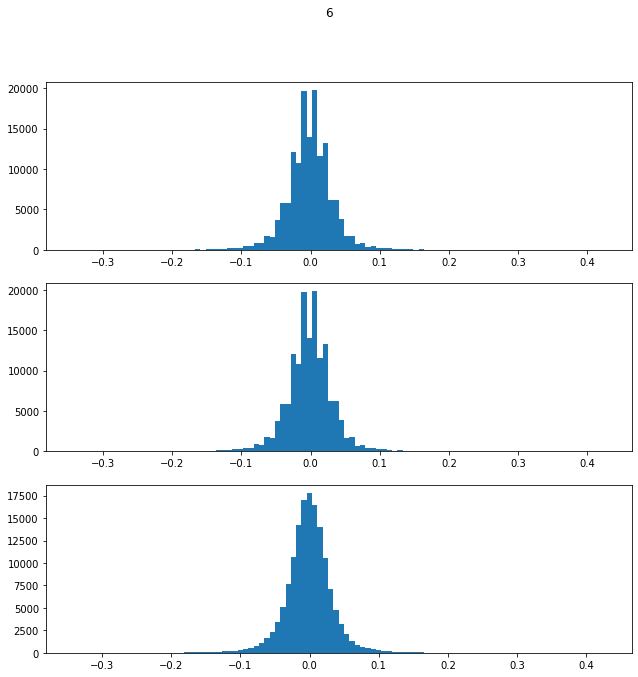

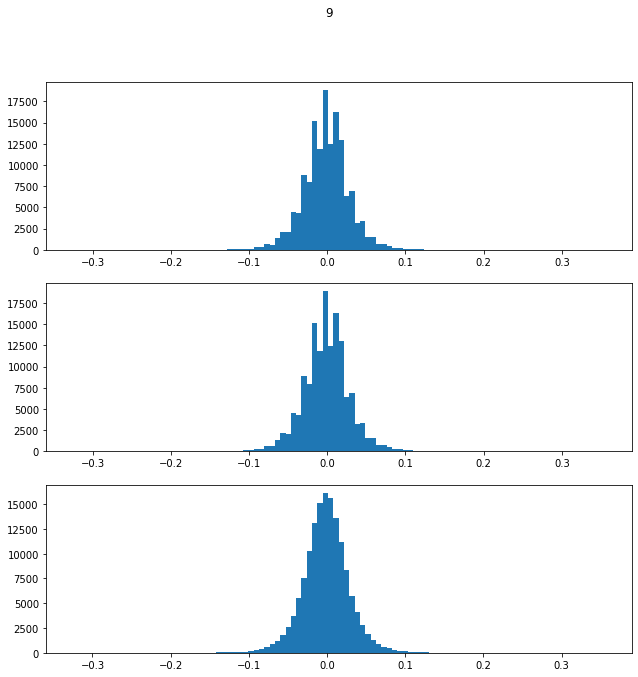

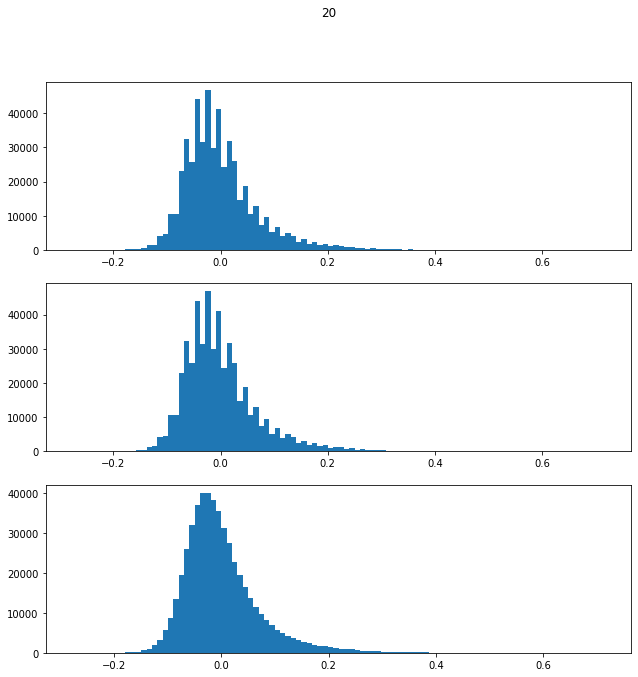

In [27]:
model = models.resnet18(pretrained=True, progress=True)
count = 0
k = 8
from torch.nn import Module, Parameter
for n,m in model.named_modules():
  if isinstance(m, nn.Conv2d):
    
    if mixed_flag[count] == 0:
      print('inside conv pc')
      print(count)
      original_weight = m.weight
      x_transform = m.weight.data.contiguous().view(m.weight.shape[0], -1)
      w_min = x_transform.min(dim=1).values
      w_max = x_transform.max(dim=1).values
      w_min_pt = torch.min(w_min)
      w_max_pt = torch.max(w_max)
      scale, zero_point = asymmetric_linear_quantization_params(
              k, w_min, w_max)
      new_quant_x = linear_quantize_pc(m.weight, scale, zero_point, inplace=False)
      n = 2**(k - 1)
      new_quant_x = torch.clamp(new_quant_x, -n, n - 1)
      quant_x = linear_dequantize_pc(new_quant_x,
                                  scale,
                                  zero_point,
                                  inplace=False)
      

      m.weight = Parameter(torch.autograd.Variable(quant_x))


    if mixed_flag[count] == 1:
      print('inside conv pt')
      print(count)
      original_weight = m.weight
      x_transform = m.weight.data.contiguous().view(m.weight.shape[0], -1)
      w_min = x_transform.min(dim=1).values
      w_max = x_transform.max(dim=1).values
      w_min_pt = torch.min(w_min)
      w_max_pt = torch.max(w_max)

      scale, zero_point = asymmetric_linear_quantization_params(
              k, w_min_pt, w_max_pt)
      new_quant_x = linear_quantize_pt(m.weight, scale, zero_point, inplace=False)
      n = 2**(k - 1)
      new_quant_x = torch.clamp(new_quant_x, -n, n - 1)
      quant_x = linear_dequantize_pt(new_quant_x,
                                  scale,
                                  zero_point,
                                  inplace=False)
      #print(quant_x.shape)
      #print(m.weight.shape)

      new_quant_x_pc = linear_quantize_pc(m.weight, scale, zero_point, inplace=False)
      n = 2**(k - 1)
      new_quant_x_pc = torch.clamp(new_quant_x_pc, -n, n - 1)
      quant_x_pc = linear_dequantize_pc(new_quant_x_pc,
                                  scale,
                                  zero_point,
                                  inplace=False)
      
      m.weight = Parameter(torch.autograd.Variable(quant_x))

      fig1, ax1 = plt.subplots(3)
      #fig.suptitle('Axes values are scaled individually by default')
      fig1.suptitle(str(count))
      fig1.set_size_inches(10.5, 10.5)
      weight_pt = np.array(quant_x.data.view(-1))
      weight_pc = np.array(quant_x_pc.data.view(-1))
      plot2 = np.array(original_weight.data.view(-1))
      ax1[0].hist(weight_pt, bins = 100)
      ax1[1].hist(weight_pc, bins = 100)
      ax1[2].hist(plot2, bins = 100)

    count = count + 1

  if isinstance(m, nn.Linear):
    if mixed_flag[count] == 0:
      print('inside linear pc')
      print(count)
      original_weight = m.weight
      x_transform = m.weight.data.detach()
      #print("x_transform")
      #print(x_transform)

      w_min = x_transform.min(dim=1).values
      w_max = x_transform.max(dim=1).values

      scale, zero_point = asymmetric_linear_quantization_params(
              k, w_min, w_max)
      new_quant_x = linear_quantize_pc(m.weight, scale, zero_point, inplace=False)
      n = 2**(k - 1)
      new_quant_x = torch.clamp(new_quant_x, -n, n - 1)
      quant_x = linear_dequantize_pc(new_quant_x,
                                  scale,
                                  zero_point,
                                  inplace=False)
      m.weight = Parameter(torch.autograd.Variable(quant_x))

    if mixed_flag[count] == 1:
      print('inside linear pt')
      print(count)
      original_weight = m.weight
      x_transform = m.weight.data.detach()
      #print("x_transform")
      #print(x_transform)

      w_min = x_transform.min(dim=1).values
      w_max = x_transform.max(dim=1).values
      w_min_pt = torch.min(w_min)
      w_max_pt = torch.max(w_max)

      scale, zero_point = asymmetric_linear_quantization_params(
              k, w_min_pt, w_max_pt)
      new_quant_x = linear_quantize_pt(m.weight, scale, zero_point, inplace=False)
      n = 2**(k - 1)
      new_quant_x = torch.clamp(new_quant_x, -n, n - 1)
      quant_x = linear_dequantize_pt(new_quant_x,
                                  scale,
                                  zero_point,
                                  inplace=False)
      

      new_quant_x_pc = linear_quantize_pc(m.weight, scale, zero_point, inplace=False)
      n = 2**(k - 1)
      new_quant_x_pc = torch.clamp(new_quant_x_pc, -n, n - 1)
      quant_x_pc = linear_dequantize_pc(new_quant_x_pc,
                                  scale,
                                  zero_point,
                                  inplace=False)
      #print(quant_x.shape)
      #print(m.weight.shape)
      
      m.weight = Parameter(torch.autograd.Variable(quant_x.reshape(m.weight.shape)))
      
      fig, ax = plt.subplots(3)
      #fig.suptitle('Axes values are scaled individually by default')
      fig.suptitle(str(count))
      fig.set_size_inches(10.5, 10.5)
      weight_pt = np.array(quant_x.data.view(-1))
      weight_pc = np.array(quant_x_pc.data.view(-1))
      plot2 = np.array(original_weight.data.view(-1))
      ax[0].hist(weight_pt, bins = 100)
      ax[1].hist(weight_pc, bins = 100)
      ax[2].hist(plot2, bins = 100)
      #plt.show()

    count = count + 1
      

In [25]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:

import torch
import time
import math
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Parameter
import sys


class QuantAct(Module):
    """
    Class to quantize given activations
    """
    def __init__(self,
                 activation_bit,
                 full_precision_flag=False,
                 running_stat=True):
        """
        activation_bit: bit-setting for activation
        full_precision_flag: full precision or not
        running_stat: determines whether the activation range is updated or froze
        """
        super(QuantAct, self).__init__()
        self.activation_bit = activation_bit
        self.momentum = 0.99
        self.full_precision_flag = full_precision_flag
        self.running_stat = running_stat
        self.register_buffer('x_min', torch.zeros(1))
        self.register_buffer('x_max', torch.zeros(1))
        self.act_function = AsymmetricQuantFunction.apply

    def __repr__(self):
        return "{0}(activation_bit={1}, full_precision_flag={2}, running_stat={3}, Act_min: {4:.2f}, Act_max: {5:.2f})".format(
            self.__class__.__name__, self.activation_bit,
            self.full_precision_flag, self.running_stat, self.x_min.item(),
            self.x_max.item())

    def fix(self):
        """
        fix the activation range by setting running stat
        """
        self.running_stat = False

    def forward(self, x):
        """
        quantize given activation x
        """
        if self.running_stat:
            x_min = x.data.min()
            x_max = x.data.max()
            # in-place operation used on multi-gpus
            self.x_min += -self.x_min + min(self.x_min, x_min)
            self.x_max += -self.x_max + max(self.x_max, x_max)

        if not self.full_precision_flag:
            quant_act = self.act_function(x, self.activation_bit, self.x_min,
                                          self.x_max)
            return quant_act
        else:
            return x


class Quant_Linear(Module):
    """
    Class to quantize given linear layer weights
    """
    def __init__(self, weight_bit, full_precision_flag=False):
        """
        weight: bit-setting for weight
        full_precision_flag: full precision or not
        running_stat: determines whether the activation range is updated or froze
        """
        super(Quant_Linear, self).__init__()
        self.full_precision_flag = full_precision_flag
        self.weight_bit = weight_bit
        self.weight_function = AsymmetricQuantFunction.apply
        #self.pc_pt_flag = 0
        self.weight_function_pt = AsymmetricQuantFunctionPT.apply

    def __repr__(self):
        s = super(Quant_Linear, self).__repr__()
        s = "(" + s + " weight_bit={}, full_precision_flag={})".format(
            self.weight_bit, self.full_precision_flag)
        return s

    def set_param(self, linear, flag):
        self.in_features = linear.in_features
        self.out_features = linear.out_features
        self.weight = Parameter(linear.weight.data.clone())
        #self.pc_pt_flag = flag
        try:
            self.bias = Parameter(linear.bias.data.clone())
        except AttributeError:
            self.bias = None

    def forward(self, x):
        """
        using quantized weights to forward activation x
        """
        w = self.weight
        '''x_transform = w.data.detach()
        w_min = x_transform.min(dim=1).values
        w_max = x_transform.max(dim=1).values

        w_min_pt = torch.min(w_min)
        w_max_pt = torch.max(w_max)'''


        '''if(self.pc_pt_flag == 0):
          if not self.full_precision_flag:
              w = self.weight_function(self.weight, self.weight_bit, w_min,
                                      w_max)
          else:
              w = self.weight

        if(self.pc_pt_flag == 1):
          if not self.full_precision_flag:
              w = self.weight_function_pt(self.weight, self.weight_bit, w_min_pt,
                                      w_max_pt)
          else:
              w = self.weight'''

        return F.linear(x, weight=w, bias=self.bias)


class Quant_Conv2d(Module):
    """
    Class to quantize given convolutional layer weights
    """
    def __init__(self, weight_bit, full_precision_flag=False):
        super(Quant_Conv2d, self).__init__()
        self.full_precision_flag = full_precision_flag
        self.weight_bit = weight_bit
        self.weight_function = AsymmetricQuantFunction.apply
        #self.pc_pt_flag = 0
        self.weight_function_pt = AsymmetricQuantFunctionPT.apply

    def __repr__(self):
        s = super(Quant_Conv2d, self).__repr__()
        s = "(" + s + " weight_bit={}, full_precision_flag={})".format(
            self.weight_bit, self.full_precision_flag)
        return s

    def set_param(self, conv, flag):
        self.in_channels = conv.in_channels
        self.out_channels = conv.out_channels
        self.kernel_size = conv.kernel_size
        self.stride = conv.stride
        self.padding = conv.padding
        self.dilation = conv.dilation
        self.groups = conv.groups
        self.weight = Parameter(conv.weight.data.clone())
        #self.pc_pt_flag = flag
        try:
            self.bias = Parameter(conv.bias.data.clone())
        except AttributeError:
            self.bias = None

    def forward(self, x):
        """
        using quantized weights to forward activation x
        """
        w = self.weight
        '''x_transform = w.data.contiguous().view(self.out_channels, -1)
        w_min = x_transform.min(dim=1).values
        w_max = x_transform.max(dim=1).values

        w_min_pt = torch.min(w_min)
        w_max_pt = torch.max(w_max)

        if(self.pc_pt_flag == 0):
          if not self.full_precision_flag:
              w = self.weight_function(self.weight, self.weight_bit, w_min,
                                      w_max)
          else:
              w = self.weight

        if(self.pc_pt_flag == 1):
          if not self.full_precision_flag:
              w = self.weight_function_pt(self.weight, self.weight_bit, w_min_pt,
                                      w_max_pt)
          else:
              w = self.weight'''

          

        return F.conv2d(x, w, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)

In [ ]:
pip install pytorchcv

     |████████████████████████████████| 440kB 2.7MB/s 


In [ ]:
import torch
import torch.nn as nn
import copy
from pytorchcv.models.common import ConvBlock
from pytorchcv.models.shufflenetv2 import ShuffleUnit, ShuffleInitBlock

#a = "ainvjdncvd"
layer_count = 0

def quantize_model(model):
    """
    Recursively quantize a pretrained single-precision model to int8 quantized model
    model: pretrained single-precision model
    """
    global layer_count
    # quantize convolutional and linear layers to 8-bit
    if type(model) == nn.Conv2d:
        quant_mod = Quant_Conv2d(weight_bit=8)
        quant_mod.set_param(model,mixed_flag[layer_count])
        return quant_mod
    elif type(model) == nn.Linear:
        quant_mod = Quant_Linear(weight_bit=8)
        quant_mod.set_param(model,mixed_flag[layer_count])
        return quant_mod

    # quantize all the activation to 8-bit
    elif type(model) == nn.ReLU or type(model) == nn.ReLU6:
        return nn.Sequential(*[model, QuantAct(activation_bit=8)])

    # recursively use the quantized module to replace the single-precision module
    elif type(model) == nn.Sequential:
        mods = []
        for n, m in model.named_children():
            mods.append(quantize_model(m))
        return nn.Sequential(*mods)
    else:
        q_model = copy.deepcopy(model)
        for attr in dir(model):
            mod = getattr(model, attr)
            if isinstance(mod, nn.Module) and 'norm' not in attr:
                setattr(q_model, attr, quantize_model(mod))
        return q_model


def freeze_model(model):
    """
    freeze the activation range
    """
    if type(model) == QuantAct:
        model.fix()
    elif type(model) == nn.Sequential:
        mods = []
        for n, m in model.named_children():
            freeze_model(m)
    else:
        for attr in dir(model):
            mod = getattr(model, attr)
            if isinstance(mod, nn.Module) and 'norm' not in attr:
                freeze_model(mod)
        return model


def unfreeze_model(model):
    """
    unfreeze the activation range
    """
    if type(model) == QuantAct:
        model.unfix()
    elif type(model) == nn.Sequential:
        mods = []
        for n, m in model.named_children():
            unfreeze_model(m)
    else:
        for attr in dir(model):
            mod = getattr(model, attr)
            if isinstance(mod, nn.Module) and 'norm' not in attr:
                unfreeze_model(mod)
        return model


In [ ]:
print(mixed_flag)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
quantized_model = quantize_model(model)

In [ ]:
from PIL import Image
import torchvision
data = torchvision.datasets.FakeData(size=100, image_size=(3, 224, 224), num_classes=10, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]), target_transform=None, random_offset=0)
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=64,
                                          shuffle=True)

In [ ]:
pip install progress

  Created wheel for progress: filename=progress-1.5-cp36-none-any.whl size=8074 sha256=2b9c6fc52c7ff20b4174c76f8298260880c6a80798c82d8613a04adfe4791f59
  Stored in directory: /root/.cache/pip/wheels/6c/c8/80/32a294e3041f006c661838c05a411c7b7ffc60ff939d14e116
Successfully built progress


In [ ]:
#*
# @file Different utility functions
# Copyright (c) Yaohui Cai, Zhewei Yao, Zhen Dong, Amir Gholami
# All rights reserved.
# This file is part of ZeroQ repository.
#
# ZeroQ is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# ZeroQ is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with ZeroQ repository.  If not, see <http://www.gnu.org/licenses/>.
#*

import torch
import os
import torch.nn as nn
from progress.bar import Bar


def test(model, test_loader):
    """
    test a model on a given dataset
    """
    total, correct = 0, 0
    bar = Bar('Testing', max=len(test_loader))
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            acc = correct / total

            bar.suffix = f'({batch_idx + 1}/{len(test_loader)}) | ETA: {bar.eta_td} | top1: {acc}'
            bar.next()
    print('\nFinal acc: %.2f%% (%d/%d)' % (100. * acc, correct, total))
    bar.finish()
    model.train()
    return acc


def update(quantized_model, distilD):
    """
    Update activation range according to distilled data
    quantized_model: a quantized model whose activation range to be updated 
    distilD: distilled data
    """
    with torch.no_grad():
        for batch_idx, inputs in enumerate(distilD):
            if isinstance(inputs, list):
                inputs = inputs[0]
            #inputs = inputs.cuda()
            outputs = quantized_model(inputs)
    return quantized_model


In [ ]:
quantized_model.eval()

ResNet(
  (conv1): (Quant_Conv2d() weight_bit=8, full_precision_flag=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sequential(
    (0): ReLU(inplace=True)
    (1): QuantAct(activation_bit=8, full_precision_flag=False, running_stat=True, Act_min: 0.00, Act_max: 0.00)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): (Quant_Conv2d() weight_bit=8, full_precision_flag=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sequential(
        (0): ReLU(inplace=True)
        (1): QuantAct(activation_bit=8, full_precision_flag=False, running_stat=True, Act_min: 0.00, Act_max: 0.00)
      )
      (conv2): (Quant_Conv2d() weight_bit=8, full_precision_flag=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBloc

In [ ]:
update(quantized_model, data_loader)

ResNet(
  (conv1): (Quant_Conv2d() weight_bit=8, full_precision_flag=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sequential(
    (0): ReLU(inplace=True)
    (1): QuantAct(activation_bit=8, full_precision_flag=False, running_stat=True, Act_min: 0.00, Act_max: 6.52)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): (Quant_Conv2d() weight_bit=8, full_precision_flag=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sequential(
        (0): ReLU(inplace=True)
        (1): QuantAct(activation_bit=8, full_precision_flag=False, running_stat=True, Act_min: 0.00, Act_max: 6.16)
      )
      (conv2): (Quant_Conv2d() weight_bit=8, full_precision_flag=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBloc

In [ ]:
freeze_model(quantized_model)

ResNet(
  (conv1): (Quant_Conv2d() weight_bit=8, full_precision_flag=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sequential(
    (0): ReLU(inplace=True)
    (1): QuantAct(activation_bit=8, full_precision_flag=False, running_stat=False, Act_min: 0.00, Act_max: 6.52)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): (Quant_Conv2d() weight_bit=8, full_precision_flag=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sequential(
        (0): ReLU(inplace=True)
        (1): QuantAct(activation_bit=8, full_precision_flag=False, running_stat=False, Act_min: 0.00, Act_max: 6.16)
      )
      (conv2): (Quant_Conv2d() weight_bit=8, full_precision_flag=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBl

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
test_dataset = datasets.ImageFolder(
    'drive/My Drive/ImageNet_samples_To_Raja',
    transforms.Compose([
        transforms.Resize(int(224 / 0.875)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))
test_loader = DataLoader(test_dataset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=32)

In [ ]:
with torch.no_grad():
  j = 0
  k = 0
  label = [367, 251, 145, 9, 84, 963, 779, 292, 889, 340]
  correct = 0
  for batch_idx, (inputs, targets) in enumerate(test_loader):
      #inputs, targets = inputs.cuda(), targets.cuda()
      outputs = quantized_model(inputs)
      for i in range(32):
        if(j < 100):
          #print(j)
          predicted = (int(torch.argmax(outputs[i])))
          if(j%10 == 0):
            curr_label = label[k]
            k = k + 1
          if(predicted == curr_label):
            #print(correct)
            correct = correct + 1
          j = j + 1

  print("accuracy")
  print(correct/100)

accuracy
0.74


In [ ]:
model_original.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
with torch.no_grad():
  j = 0
  k = 0
  label = [367, 251, 145, 9, 84, 963, 779, 292, 889, 340]
  correct = 0
  for batch_idx, (inputs, targets) in enumerate(test_loader):
      #inputs, targets = inputs.cuda(), targets.cuda()
      outputs = model_original(inputs)
      for i in range(32):
        if(j < 100):
          #print(j)
          predicted = (int(torch.argmax(outputs[i])))
          if(j%10 == 0):
            curr_label = label[k]
            k = k + 1
          if(predicted == curr_label):
            #print(correct)
            correct = correct + 1
          j = j + 1

  print("accuracy")
  print(correct/100)

accuracy
0.74


In [ ]:
#model.conv1.weight

In [ ]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import numpy as np
import pandas as pd
weight_temp = model.conv1.weight
temp = weight_temp.detach().numpy()
print(temp.shape)
imgs = weight_temp.detach().numpy()[:, ::-1, :, :]
print(imgs.shape)
x = temp.flatten()
#print(x.shape)
x = x.reshape(64,-1)
print(x.shape)

print(weight_temp[0])
print(x[0])


(64, 3, 7, 7)
(64, 3, 7, 7)
(64, 147)
tensor([[[-0.0107, -0.0053,  0.0000,  0.0748,  0.0588,  0.0160, -0.0107],
         [ 0.0107,  0.0107, -0.1123, -0.2780, -0.2726, -0.1283,  0.0053],
         [-0.0053,  0.0588,  0.2940,  0.5880,  0.5185,  0.2566,  0.0641],
         [ 0.0321, -0.0695, -0.2993, -0.4383, -0.2726,  0.0000,  0.0588],
         [-0.0267,  0.0160,  0.0748, -0.0535, -0.3314, -0.4223, -0.2566],
         [ 0.0321,  0.0428,  0.0641,  0.2405,  0.4116,  0.3956,  0.1657],
         [-0.0160, -0.0053, -0.0267, -0.0641, -0.1497, -0.0802, -0.0053]],

        [[-0.0107, -0.0267, -0.0321,  0.0374,  0.0321,  0.0000, -0.0267],
         [ 0.0481,  0.0321, -0.1069, -0.3100, -0.3100, -0.1604,  0.0000],
         [ 0.0000,  0.0962,  0.4009,  0.7697,  0.7056,  0.3688,  0.1229],
         [-0.0053, -0.1283, -0.4223, -0.5933, -0.3849, -0.0428,  0.0641],
         [-0.0535, -0.0053,  0.0267, -0.1497, -0.4597, -0.5719, -0.3635],
         [ 0.0321,  0.0535,  0.1016,  0.3207,  0.5452,  0.4811,  0.1978]

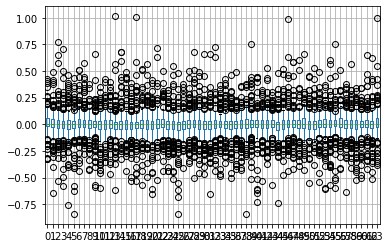

In [38]:
import numpy as np
import pandas as pd
weight_temp = model.conv1.weight
temp = weight_temp.detach().numpy()
#print(temp)
imgs = weight_temp.detach().numpy()[:, ::-1, :, :]

x = temp.flatten()
x = x.reshape(-1, 64)
#print(x)
#print(np.shape(x))
df = pd.DataFrame(x)
df.plot.box(grid = True)

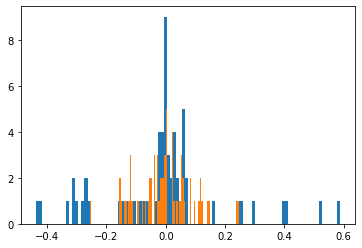

In [39]:
import matplotlib.pyplot as plt
plot2 = np.array(x[0])
plotx = np.array(x[2])
abc = plt.hist(plot2, bins = 100)
abcx = plt.hist(plotx, bins = 100)
plt.show()

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 2., 1., 0., 1., 1., 0., 1., 3., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 2., 2., 0., 3., 0., 3., 1., 2., 2., 2., 3.,
        5., 0., 0., 0., 4., 1., 0., 1., 0., 1., 3., 2., 1., 0., 0., 0., 2.,
        0., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
 array([-0.25657317, -0.25154862, -0.24652405, -0.2414995 , -0.23647493,
        -0.23145038, -0.22642583, -0.22140126, -0.2163767 , -0.21135215,
        -0.20632759, -0.20130304, -0.19627847, -0.19125392, -0.18622936,
        -0.1812048 , -0.17618024, -0.17115569, -0.16613112, -0.16110657,
        -0.156082  , -0.15105745, -0.1460329 , -0.14100833, -0.13598378,
        -0.13095921, -0.12593466, -0.1209101 , -0.11588555, -0.11086099,
        -0.10583643, -0.10081187, -0.09578732, -0.09076276, -0.0857382 ,
        -0.08071364, -0.07568908, -0.07

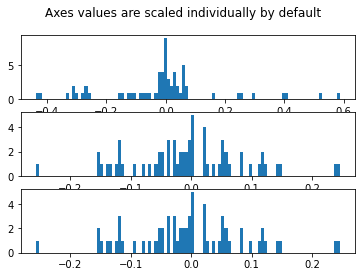

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Axes values are scaled individually by default')
ax1.hist(plot2, bins = 100)
ax2.hist(plotx, bins = 100)
ax3.hist(plotx, bins = 100)

(array([40., 40., 40., 40., 40., 40., 40., 40., 40., 40.]),
 array([0.        , 0.62831853, 1.25663706, 1.88495559, 2.51327412,
        3.14159265, 3.76991118, 4.39822972, 5.02654825, 5.65486678,
        6.28318531]),
 <a list of 10 Patch objects>)

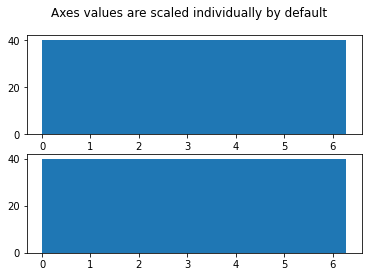

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Axes values are scaled individually by default')
ax1.hist(x)
ax2.hist(x)